### Training the NN to get log_prob.

In [1]:
import numpy as np
from typing import Sequence
import jax, jax.numpy as jnp
from flax import linen as nn
import optax
from flax.training import train_state
from functools import partial

import corner

import TrainLogLik as NN

import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

plt.style.use(['seaborn-v0_8-ticks','seaborn-v0_8-deep'])

# %pylab inline

mpl.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (12,7)

%load_ext autoreload
%autoreload 2


/opt/anaconda3/envs/torch_env3_11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#### reading the data for training
import pickle


with open('run_info_data.pkl', 'rb') as f:
    run_info = pickle.load(f)

In [3]:
ds = run_info["dataset"]
X_raw = ds["X"]                # (N, 24)
y     = ds["y_logprob"]        # (N,)
T     = ds["temperature"]      # (N,) if you ever need it

Nsrc = 3
Npar_src=8

fold_idx = (4, 6, 7, 4+Npar_src, 6+Npar_src, 7+Npar_src, 4+2*Npar_src, 6+2*Npar_src, 7+2*Npar_src)

print (X_raw.shape, y.shape, T.shape)

(2400012, 24) (2400012,) (2400012,)


False

Indices of NaNs in y:
721


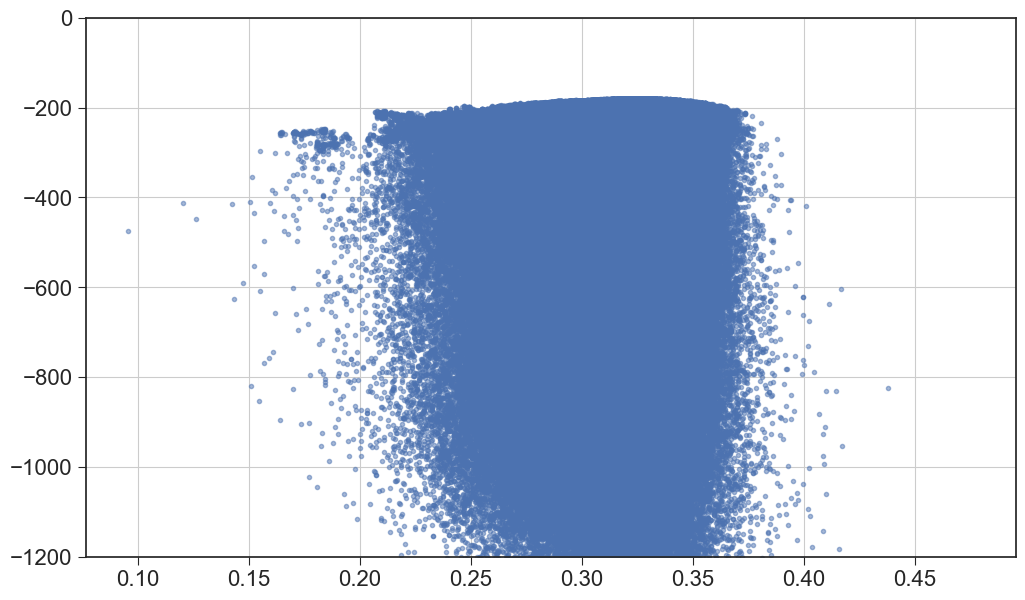

(2399291,) (2399291, 24)
above threshold (2396603,)
(2396603,) (2396603, 24)
(2396603, 33) (2396603,)
{'x_mean': array([ 0.3171365 ,  0.4891049 ,  0.47776452,  0.61233205,  0.607059  ,
        0.37808967,  0.8467531 ,  0.6418651 ,  0.41687888,  0.3767656 ,
        0.3201503 ,  0.7257884 ,  0.498776  ,  0.07770665,  0.4514554 ,
       -0.99723494, -0.42104304,  0.17942327, -0.99457574,  0.27622393,
        0.72498715,  0.15754966, -0.15527856, -0.16585456,  0.04614916,
       -0.3732156 ,  0.44024223, -0.09644998,  0.57975113,  0.00897464,
       -0.9669364 ,  0.35223094, -0.47992444], dtype=float32), 'x_std': array([0.01800187, 0.01109281, 0.17523082, 0.05848542, 0.04258619,
       0.01410155, 0.00709141, 0.11071675, 0.04240955, 0.03228238,
       0.04084374, 0.02767036, 0.29473698, 0.02511493, 0.07276737,
       0.0047187 , 0.5999633 , 0.65450853, 0.00451652, 0.58558875,
       0.4367652 , 0.19433548, 0.6688332 , 0.67674863, 0.05805712,
       0.5687501 , 0.58788824, 0.03868264, 0.494

In [4]:
has_nan = np.isnan(X_raw).any()
print (has_nan)

nan_indices_y = np.where(np.isnan(y))
if nan_indices_y[0].size > 0:
    print("\nIndices of NaNs in y:")
    print(nan_indices_y[0].size)
else:
    print("\nNo NaN values found in y.")

valid_mask = ~np.isnan(y) & ~np.isnan(X_raw).any(axis=1)

X_filtered = X_raw[valid_mask]
y_filtered = y[valid_mask]

ind = 0
threshold = -1200
plt.plot(X_filtered[:, ind], y_filtered, '.', alpha=0.5)
plt.ylim([threshold, 0])
plt.show()


print (y_filtered.shape, X_filtered.shape)
inds = np.argwhere(y_filtered> threshold)[..., 0]
print ('above threshold', inds.shape)
X_filtered = X_filtered[inds, :]
y_filtered = y_filtered[inds]
print (y_filtered.shape, X_filtered.shape)


Xn, yn, meta = NN.build_features(
    X_filtered, y_filtered, periodic_idx=fold_idx, period=1.0, add_invT=False, T=None)

print (Xn.shape, yn.shape)
print (meta)

Xn = Xn[::2, :]
yn = yn[::2]

print (Xn.shape, yn.shape)

## Start from ghere!

In [2]:
### The latest run

sub = np.load("ptdmh_surrogate_subset.npz")

X   = sub["X"]              # (N, D) float32
y   = sub["y_center"]       # (N,)   float32 (<= 0)
y_raw = sub["y_raw"]        # (N,)   float32 (original log-lik)
T   = sub["temperature"]    # (N,)   float32 (absolute temperature)
chain = sub["chain"]        # (N,)   int32   (temperature slot id)
acc   = sub["accepted"]     # (N,)   bool
comp  = sub["comp"]         # (N,)   int32   (proposal id: 0/1/2)
w     = sub["weights"]      # (N,)   float32 (sampling weights)
edges = sub["quantile_edges"]  # (n_bins+1,)

print ('y_mean =', max(y_raw))

y_mean = -180.47157


above threshold (499527,)
(499527,) (499527, 24)


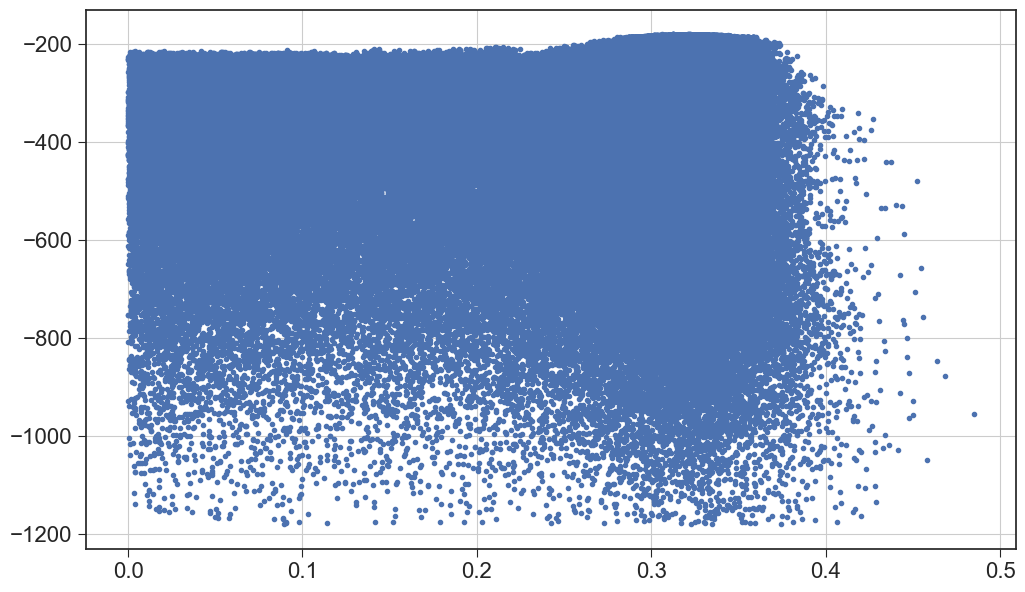


No NaN values found in y.


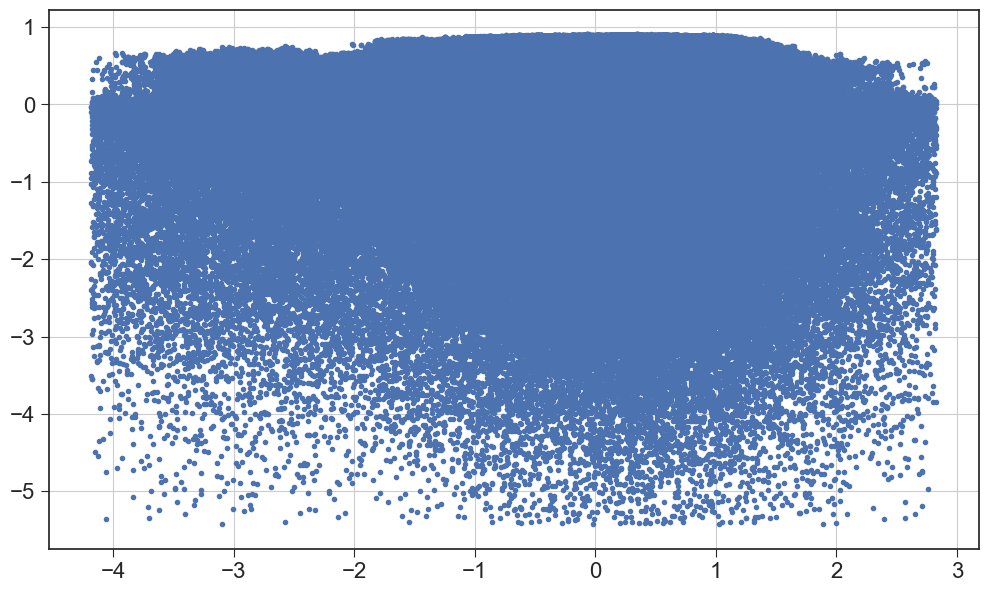

In [3]:
Nsrc = 3
Npar_src=8

fold_idx = (4, 6, 7, 4+Npar_src, 6+Npar_src, 7+Npar_src, 4+2*Npar_src, 6+2*Npar_src, 7+2*Npar_src)


threshold = -1_000
inds = np.argwhere(y> threshold)[..., 0]
print ('above threshold', inds.shape)
X_filtered = X[inds, :]
y_filtered = y_raw[inds]
print (y_filtered.shape, X_filtered.shape)
plt.plot(X_filtered[:, 0], y_filtered, '.')
plt.show()

nan_indices_y = np.where(np.isnan(y_raw))
if nan_indices_y[0].size > 0:
    print("\nIndices of NaNs in y:")
    print(nan_indices_y[0].size)
else:
    print("\nNo NaN values found in y.")

Xn, yn, meta = NN.build_features(X_filtered, y_filtered, periodic_idx=fold_idx, period=1.0, add_invT=False, T=None)

plt.plot(Xn[:, 3], yn, '.')
plt.show()

In [4]:
def make_weights_from_yn(yn: np.ndarray, *, scheme="exp", alpha=1.0,
                         clip_lo=0.2, clip_hi=5.0) -> np.ndarray:
    """
    Build per-sample weights emphasizing large yn (high log-prob region).
    yn must be the standardized target from build_features.
    - scheme="exp":   w = exp(alpha * yn)
    - scheme="sig":   w = sigmoid(alpha * yn)
    """
    yn = np.asarray(yn, dtype=np.float32)
    if scheme == "exp":
        w = np.exp(alpha * yn)
    elif scheme == "sig":
        w = 1.0 / (1.0 + np.exp(-alpha * yn))
    else:
        raise ValueError("scheme must be 'exp' or 'sig'")
    w = np.clip(w, clip_lo, clip_hi).astype(np.float32)
    return w

def save_memmap(path_X, path_y, X, y, dtype=np.float32):
    Xmm = np.memmap(path_X, mode='w+', dtype=dtype, shape=X.shape)
    ymm = np.memmap(path_y, mode='w+', dtype=dtype, shape=y.shape)
    Xmm[:] = X.astype(dtype); Xmm.flush()
    ymm[:] = y.astype(dtype); ymm.flush()
    return path_X, path_y

def save_memmap_with_w(path_X, path_y, path_w, X, y, w,
                       dtype=np.float32):
    save_memmap(path_X, path_y, X, y, dtype=dtype)
    wmm = np.memmap(path_w, mode='w+', dtype=dtype, shape=w.shape)
    wmm[:] = w.astype(dtype); wmm.flush()
    return path_X, path_y, path_w

def load_memmap(path_X, path_y, shape_X, shape_y, dtype=np.float32):
    Xmm = np.memmap(path_X, mode='r', dtype=dtype, shape=shape_X)
    ymm = np.memmap(path_y, mode='r', dtype=dtype, shape=shape_y)
    return Xmm, ymm

def load_memmap_with_w(path_X, path_y, path_w, shape_X, shape_y, shape_w,
                       dtype=np.float32):
    Xmm, ymm = load_memmap(path_X, path_y, shape_X, shape_y, dtype=dtype)
    wmm = np.memmap(path_w, mode='r', dtype=dtype, shape=shape_w)
    return Xmm, ymm, wmm

def split_train_val_memmap(Xmm, ymm, wmm=None, val_frac=0.1, block=True):
    N = len(Xmm); n_val = int(N * val_frac)
    if block:
        tr, va = slice(0, N - n_val), slice(N - n_val, N)
        if wmm is None:
            return (Xmm[tr], ymm[tr]), (Xmm[va], ymm[va])
        else:
            return (Xmm[tr], ymm[tr], wmm[tr]), (Xmm[va], ymm[va], wmm[va])
    else:
        idx = np.arange(N); np.random.shuffle(idx)
        tr_idx, va_idx = idx[n_val:], idx[:n_val]
        if wmm is None:
            return (Xmm[tr_idx], ymm[tr_idx]), (Xmm[va_idx], ymm[va_idx])
        else:
            return (Xmm[tr_idx], ymm[tr_idx], wmm[tr_idx]), (Xmm[va_idx], ymm[va_idx], wmm[va_idx])

def memmap_loader(Xmm, ymm, batch, wmm=None, shuffle=True, seed=0):
    N = len(Xmm)
    order = np.arange(N)
    if shuffle:
        rng = np.random.default_rng(seed); rng.shuffle(order)
    for i in range(0, N, batch):
        idx = order[i:i+batch]
        Xb = np.asarray(Xmm[idx])
        yb = np.asarray(ymm[idx])
        if wmm is None:
            wb = np.ones((len(idx),), dtype=np.float32)
        else:
            wb = np.asarray(wmm[idx], dtype=np.float32)
        yield Xb, yb, wb


In [5]:
wn = make_weights_from_yn(yn)


save_memmap_with_w("Xn.dat", "yn.dat", "wn.dat", Xn, yn, wn)
Xmm, ymm, wmm = load_memmap_with_w("Xn.dat", "yn.dat", "wn.dat", Xn.shape, yn.shape, wn.shape)
(Xtr, ytr, wtr), (Xva, yva, wva) = split_train_val_memmap(Xmm, ymm, wmm, val_frac=0.1, block=True)

In [6]:
### Let me have a look at the training data

print (Xtr.shape, ytr.shape)

(449575, 33) (449575,)


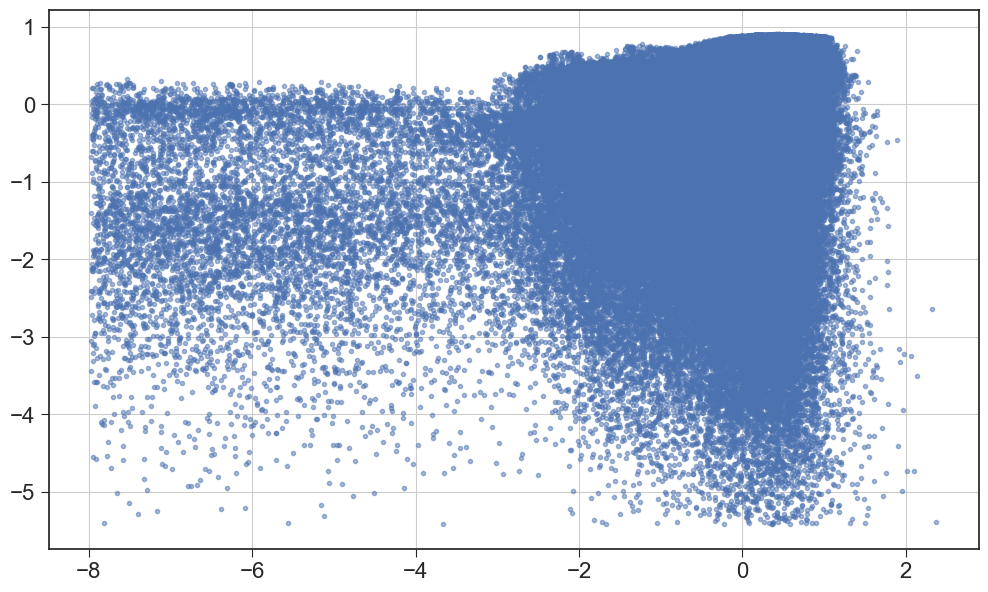

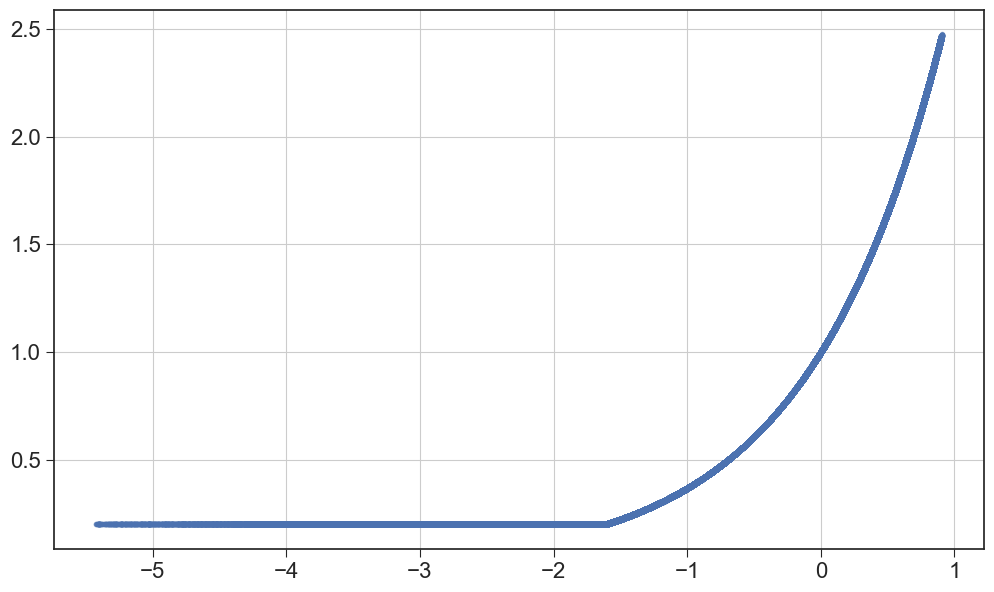

In [7]:
ind = 5
plt.plot(Xtr[:, ind], ytr, '.', alpha=0.5)
plt.show()

# yn = ((ytr - np.mean(ytr)) / np.std(ytr)).astype(np.float32)
# w = np.exp(1.0*yn) 
plt.plot(ytr, wtr, '.', alpha=0.5)
plt.show()






In [ ]:
Nsmpls = len(ytr)
batch = 8192
epochs = 150

model = NN.LogProbNet(widths=(256, 256, 256, 256), blocks_per_layer=2, dropout=0.1, heteroscedastic=True)
# model = NN.LogProbNet(widths=(512,512,512,512), blocks_per_layer=2, dropout=0.1, heteroscedastic=True)
rng = jax.random.PRNGKey(0)
params = model.init(rng, jnp.zeros((1, Xn.shape[1])), train=False)['params']
# steps = int(np.ceil(len(Xtr)/8192)) * 150
# tx = NN.make_optimizer(lr=3e-4, weight_decay=1e-4, steps=steps, clip_norm=1.0)


# steps = int(np.ceil(len(Xtr)/8192)) * 150 * int(np.ceil(8192/1024))
steps = np.ceil(Nsmpls / batch) * epochs
tx, lr_schedule = NN.make_optimizer(steps, peak_lr=3e-4, end_lr=1e-5,
                                 warmup_frac=0.05, weight_decay=1e-4, clip_norm=1.0)

# Train with accum (e.g., batch=8192 via 8×1024 microbatches)

best_params, summary = NN.train_with_accum(
    model, params, tx, Xtr, ytr, Xva, yva,
    Wtr=wtr, Wva=wva,        # or None
    heteroscedastic=True,
    batch=batch, microbatch=1024, epochs=epochs, seed=0,
    val_weighted=False             # report unweighted val loss
)

Training:   1%|          | 1/150 [00:23<57:33, 23.18s/it]

Epoch 1/150 | Val loss: 2.1543 | Best: 2.1543 | Bad epochs: 0


Training:   1%|▏         | 2/150 [00:43<52:29, 21.28s/it]

Epoch 2/150 | Val loss: 3.0853 | Best: 2.1543 | Bad epochs: 1


Training:   2%|▏         | 3/150 [01:02<49:52, 20.36s/it]

Epoch 3/150 | Val loss: 3.7929 | Best: 2.1543 | Bad epochs: 2


Training:   3%|▎         | 4/150 [01:22<49:44, 20.44s/it]

Epoch 4/150 | Val loss: 4.1583 | Best: 2.1543 | Bad epochs: 3


Training:   3%|▎         | 5/150 [01:44<50:36, 20.94s/it]

Epoch 5/150 | Val loss: 3.5875 | Best: 2.1543 | Bad epochs: 4


Training:   4%|▍         | 6/150 [02:04<49:38, 20.69s/it]

Epoch 6/150 | Val loss: 2.7402 | Best: 2.1543 | Bad epochs: 5


Training:   5%|▍         | 7/150 [02:25<49:26, 20.74s/it]

Epoch 7/150 | Val loss: 2.4793 | Best: 2.1543 | Bad epochs: 6


Training:   5%|▌         | 8/150 [02:48<50:25, 21.30s/it]

Epoch 8/150 | Val loss: 2.6216 | Best: 2.1543 | Bad epochs: 7


Training:   6%|▌         | 9/150 [03:08<49:23, 21.01s/it]

Epoch 9/150 | Val loss: 2.7321 | Best: 2.1543 | Bad epochs: 8


Training:   7%|▋         | 10/150 [03:28<48:18, 20.71s/it]

Epoch 10/150 | Val loss: 2.7129 | Best: 2.1543 | Bad epochs: 9


Training:   7%|▋         | 11/150 [03:49<47:45, 20.62s/it]

Epoch 11/150 | Val loss: 1.8560 | Best: 1.8560 | Bad epochs: 0


Training:   8%|▊         | 12/150 [04:09<47:05, 20.47s/it]

Epoch 12/150 | Val loss: 1.7089 | Best: 1.7089 | Bad epochs: 0


Training:   9%|▊         | 13/150 [04:29<46:51, 20.52s/it]

Epoch 13/150 | Val loss: 1.5466 | Best: 1.5466 | Bad epochs: 0


Training:   9%|▉         | 14/150 [04:50<46:16, 20.42s/it]

Epoch 14/150 | Val loss: 1.3147 | Best: 1.3147 | Bad epochs: 0


Training:  10%|█         | 15/150 [05:13<48:10, 21.41s/it]

Epoch 15/150 | Val loss: 1.9136 | Best: 1.3147 | Bad epochs: 1


Training:  11%|█         | 16/150 [05:36<48:31, 21.73s/it]

Epoch 16/150 | Val loss: 1.5084 | Best: 1.3147 | Bad epochs: 2


Training:  11%|█▏        | 17/150 [05:58<48:43, 21.98s/it]

Epoch 17/150 | Val loss: 1.3119 | Best: 1.3119 | Bad epochs: 0


Training:  12%|█▏        | 18/150 [06:23<49:55, 22.69s/it]

Epoch 18/150 | Val loss: 1.0625 | Best: 1.0625 | Bad epochs: 0


Training:  13%|█▎        | 19/150 [06:44<48:43, 22.32s/it]

Epoch 19/150 | Val loss: 0.7352 | Best: 0.7352 | Bad epochs: 0


Training:  13%|█▎        | 20/150 [07:05<47:24, 21.88s/it]

Epoch 20/150 | Val loss: 0.8485 | Best: 0.7352 | Bad epochs: 1


Training:  14%|█▍        | 21/150 [07:28<47:33, 22.12s/it]

Epoch 21/150 | Val loss: 1.0910 | Best: 0.7352 | Bad epochs: 2


Training:  15%|█▍        | 22/150 [07:49<46:36, 21.85s/it]

Epoch 22/150 | Val loss: 1.1759 | Best: 0.7352 | Bad epochs: 3


Training:  15%|█▌        | 23/150 [08:13<47:27, 22.42s/it]

Epoch 23/150 | Val loss: 0.8012 | Best: 0.7352 | Bad epochs: 4


Training:  16%|█▌        | 24/150 [08:35<47:15, 22.50s/it]

Epoch 24/150 | Val loss: 0.6973 | Best: 0.6973 | Bad epochs: 0


Training:  17%|█▋        | 25/150 [08:55<44:47, 21.50s/it]

Epoch 25/150 | Val loss: 0.6293 | Best: 0.6293 | Bad epochs: 0


Training:  17%|█▋        | 26/150 [09:14<43:10, 20.89s/it]

Epoch 26/150 | Val loss: 0.8071 | Best: 0.6293 | Bad epochs: 1


Training:  18%|█▊        | 27/150 [09:33<41:57, 20.47s/it]

Epoch 27/150 | Val loss: 0.9222 | Best: 0.6293 | Bad epochs: 2


Training:  19%|█▊        | 28/150 [09:53<41:13, 20.27s/it]

Epoch 28/150 | Val loss: 0.8513 | Best: 0.6293 | Bad epochs: 3


Training:  19%|█▉        | 29/150 [10:14<40:57, 20.31s/it]

Epoch 29/150 | Val loss: 0.7508 | Best: 0.6293 | Bad epochs: 4


Training:  20%|██        | 30/150 [10:33<40:01, 20.02s/it]

Epoch 30/150 | Val loss: 0.5291 | Best: 0.5291 | Bad epochs: 0


Training:  21%|██        | 31/150 [10:52<39:14, 19.79s/it]

Epoch 31/150 | Val loss: 0.4812 | Best: 0.4812 | Bad epochs: 0


Training:  21%|██▏       | 32/150 [11:13<39:28, 20.07s/it]

Epoch 32/150 | Val loss: 0.5192 | Best: 0.4812 | Bad epochs: 1


Training:  22%|██▏       | 33/150 [11:32<38:38, 19.82s/it]

Epoch 33/150 | Val loss: 0.6130 | Best: 0.4812 | Bad epochs: 2


Training:  23%|██▎       | 34/150 [11:52<37:59, 19.65s/it]

Epoch 34/150 | Val loss: 0.6324 | Best: 0.4812 | Bad epochs: 3


Training:  23%|██▎       | 35/150 [12:11<37:18, 19.47s/it]

Epoch 35/150 | Val loss: 0.6260 | Best: 0.4812 | Bad epochs: 4


Training:  24%|██▍       | 36/150 [12:29<36:36, 19.26s/it]

Epoch 36/150 | Val loss: 0.4196 | Best: 0.4196 | Bad epochs: 0


Training:  25%|██▍       | 37/150 [12:48<36:11, 19.21s/it]

Epoch 37/150 | Val loss: 0.2617 | Best: 0.2617 | Bad epochs: 0


Training:  25%|██▌       | 38/150 [13:08<35:49, 19.19s/it]

Epoch 38/150 | Val loss: 0.4061 | Best: 0.2617 | Bad epochs: 1


Training:  26%|██▌       | 39/150 [13:27<35:36, 19.25s/it]

Epoch 39/150 | Val loss: 0.4539 | Best: 0.2617 | Bad epochs: 2


Training:  27%|██▋       | 40/150 [13:46<35:08, 19.17s/it]

Epoch 40/150 | Val loss: 0.4744 | Best: 0.2617 | Bad epochs: 3


In [14]:
# Epoch 113/150 | Val loss: -0.1057 | Best: -0.1628 | Bad epochs: 20

meta["model_cfg"] = dict(
    widths=(256, 256, 256, 256), 
    blocks_per_layer=2, 
    dropout=0.1, 
    heteroscedastic=True
)

saved_model = {
    "params": jax.device_get(best_params),  # move from device to host
    "meta": meta,                           # from build_features(...)
    "version": "logprob-net:1"
}

with open("trained_loglik_modelv3.pkl", "wb") as f:
    pickle.dump(saved_model, f, protocol=pickle.HIGHEST_PROTOCOL)

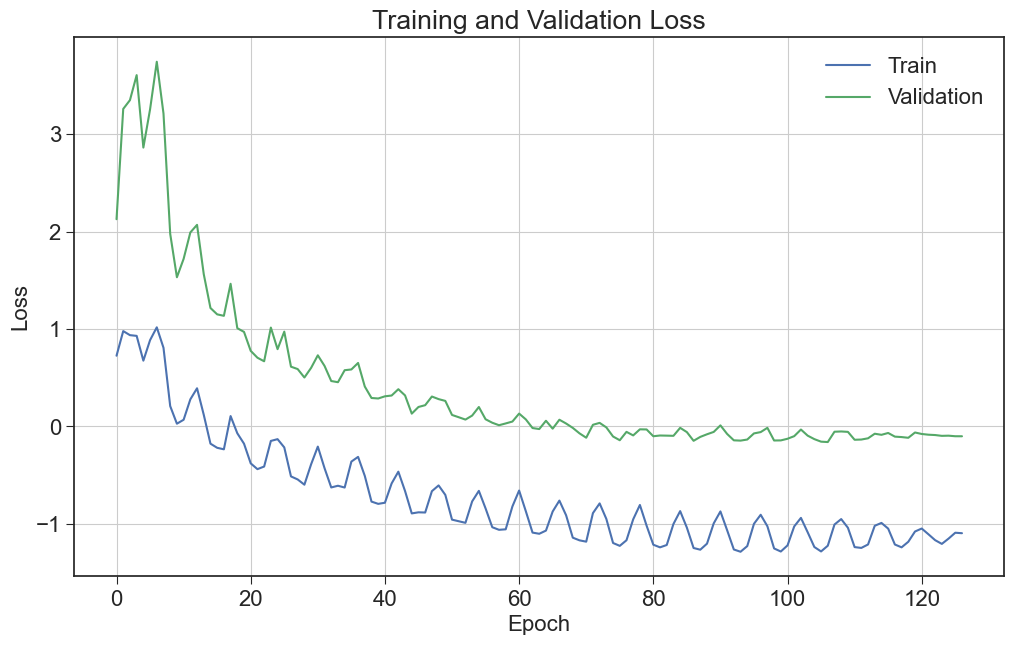

In [15]:
train_losses = summary['train_losses']
val_losses = summary['val_losses']

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

In [34]:
import pickle

In [ ]:
# Example: evaluate log-prob for a batch of parameter vectors
X_new = jnp.array([[0.1, 0.2, 0.3, 0.4],
                   [0.5, 0.6, 0.7, 0.8]])  # shape (B, dim)

# Put into the same preprocessing / normalization as training data
# e.g., if you standardized Xtr, apply the same scaler here.

# Forward pass through trained model
logp_pred = model.apply({"params": best_params}, X_new, train=False)

print("Predicted log-probs:", logp_pred)

# --- If heteroscedastic=True during training ---
# the model outputs (mu, logvar) instead of a single value
# Example:
# mu, logv = model.apply({"params": best_params}, X_new, train=False)
# print("Pred mean:", mu)
# print("Pred std:", jnp.exp(0.5 * logv))

# You can also jit for speed if used inside MCMC
predict_fn = jax.jit(lambda x: model.apply({"params": best_params}, x, train=False))
print(predict_fn(X_new))

In [ ]:
### training:

# model, state, summ = train_logprob_net(
#     Xn, yn,
#     heteroscedastic=False,
#     widths=(512,512,512,512), blocks=2, dropout=0.0,
#     batch=4096, epochs=250, lr=3e-4, weight_decay=1e-4,
#     val_frac=0.1, val_block=True, seed=0
# )